# Hands on Diffusion model

[Diffusion models](https://arxiv.org/pdf/2006.11239.pdf) are a family of models that have shown amazing capability of generating photorealistic images with/ without text prompt. They have two flows as shown in the figure below - 
1. Deterministic forward flow (from image to noise) and 
2. Generative reverse flow (recreating image from noise).

Diffusion models get their name from the forward flow where they follow a markov chain of diffusion steps, each of which adds a small amount of random noise to the data. Then they learn the model to reverse the diffusion process and construct desired data samples from noise. 

<figure>
<p style="text-align:center;"  align = "center"><img src="https://developer-blogs.nvidia.com/wp-content/uploads/2022/04/Fixed_Forward_Diffusion_Process.png" alt="Trulli" style="width:100%"  align = "center"></p>
<figcaption align = "center">Forward and reverse process <a href="https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-1/">Ref: Nvidia blog</a> </figcaption>
</figure>
 


Since they map noise to data, these models can be said to be capable of learning the distributions that generate data of any particular domain.

This notebook showcases a minimal example of the forward diffusion process and its reverse mapping using a dense network. It is meant to give the reader side by side code snippets to match the equations in the paper and visual examples of the complete process.

### Imports and utility functions

In [263]:
#@title
! pip install celluloid
import math
import tensorflow as tf

from random import randrange

import array as arr

import numpy as np
from numpy import asarray, ndarray
from IPython.display import HTML, Image, display

from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

#from celluloid import Camera
import functools
import sklearn.datasets

# For plotting
from IPython.display import HTML
from base64 import b64encode

greyscale array 
[[  0   0 135   0   0]
 [  0 135 135   0   0]
 [135   0 135   0   0]
 [  0   0 135   0   0]
 [135 135 135 135 135]]
normalized_array 
[[-0.5 -0.5  0.5 -0.5 -0.5]
 [-0.5  0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5  0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5 -0.5 -0.5]
 [ 0.5  0.5  0.5  0.5  0.5]]
width 
5
normalized_list 
[[-0.5, -0.5, 0.5, -0.5, -0.5], [-0.5, 0.5, 0.5, -0.5, -0.5], [0.5, -0.5, 0.5, -0.5, -0.5], [-0.5, -0.5, 0.5, -0.5, -0.5], [0.5, 0.5, 0.5, 0.5, 0.5]]
one_d_image_data 
[-0.5, -0.5, 0.5, -0.5, -0.5, -0.5, 0.5, 0.5, -0.5, -0.5, 0.5, -0.5, 0.5, -0.5, -0.5, -0.5, -0.5, 0.5, -0.5, -0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


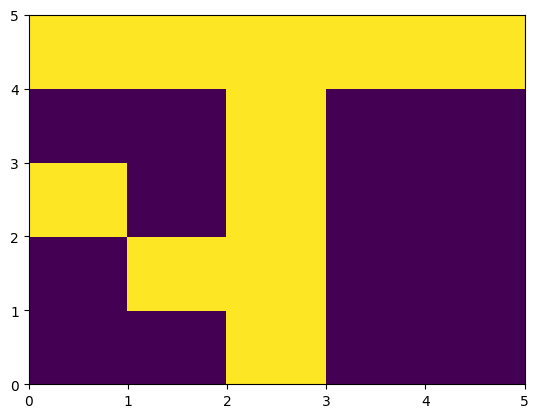

In [264]:
# Utility function for random noise
def noise_like(shape):
  return tf.random.normal(shape=shape, dtype=tf.float32)


all_data = []
one_d_image_data = []



#imagining a for i in [allimages]

  #image.open 
  #image array it
  #normalize
    #?????
  #turn normalized into one dimensional list 
  #append to alldata
  #DONT empty one dimension list
#DONT set alldata to zero 
#it messed me up later because of how datalist and one dimension list get handled or turned into tf objects. dont mess with this stuff yet


myImage = Image.open("/Users/Justin/Downloads/pixel_one.png").convert('L')
plt.pcolor(myImage)
#5 width, 5 height
#original image is transparent but gets black background once greyscaled


greyscale_array = asarray(myImage)
print("greyscale array ")
print(greyscale_array)
plt.pcolor(greyscale_array)

#it's a grey and black image. the background is black; the one is

stat_normalized_array = (greyscale_array - greyscale_array.min()) * ((0.5+ 0.5)/(greyscale_array.max()- greyscale_array.min())) - 0.5 
#Normalized Image = (Original image - min of image) * ((newMax-newMin) / (ImageMax - ImageMin)) + newMin
# 0.5 + 0.5 because 0.5 - (-0.5)
print("normalized_array ")
print(stat_normalized_array)
plt.pcolor(stat_normalized_array)

width = len(stat_normalized_array[0])
print("width ")
print(width)

#everything is black 
#(Image.fromarray(stat_normalized_array)).show()

stat_normalized_list = stat_normalized_array.tolist()
print("normalized_list ")
print( stat_normalized_list)
for i in stat_normalized_list:
  for n in i:
    one_d_image_data.append(n)

all_data.append(one_d_image_data)
print("one_d_image_data ")
print(one_d_image_data)




#when i "normalize" the iamge should i normalize it statistically 
# or by mapping all the values relative to 1 and 0 (that is, divide everything by 255 and then subtract 0.5)

## Beta schedule

Now that we have the original (non noisy) data, let's start now with the actual diffusion implementation. The first thing is to add noise to the input images following a fixed variance schedule (also known as beta schedule). The original paper uses a linear schedule. And 1000 timesteps to move forward and back. We use smaller number of timesteps (250) as the data is simpler in our case.

In [265]:
num_diffusion_timesteps=10
beta_start=0.0001
beta_end=0.02
schedule_type='quadratic'

def get_beta_schedule(schedule_type, beta_start, beta_end, num_diffusion_timesteps):
  if schedule_type == 'quadratic':
    betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps, dtype=np.float32) ** 2
  elif schedule_type == 'linear':
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float32)
  print(betas)
  print(type(betas))
  print(betas.shape)
  return betas

betas_linear = get_beta_schedule('linear', beta_start, beta_end, num_diffusion_timesteps)
betas_quad = get_beta_schedule('quadratic', beta_start, beta_end, num_diffusion_timesteps)



[9.9999997e-05 2.3111112e-03 4.5222221e-03 6.7333332e-03 8.9444444e-03
 1.1155556e-02 1.3366667e-02 1.5577778e-02 1.7788889e-02 2.0000000e-02]
<class 'numpy.ndarray'>
(10,)
[9.9999997e-05 6.0527673e-04 1.5370122e-03 2.8952057e-03 4.6798592e-03
 6.8909698e-03 9.5285391e-03 1.2592567e-02 1.6083054e-02 2.0000001e-02]
<class 'numpy.ndarray'>
(10,)


### Visualize beta schedules

The below plot shows that the variance of noise is low at the start and increases as we move forward in time.

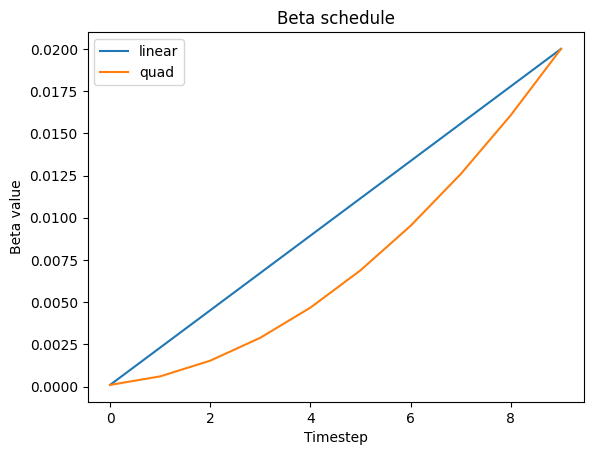

In [266]:
#@title

plt.plot(betas_linear, label = 'linear')
plt.plot(betas_quad, label='quad')
plt.title('Beta schedule')
plt.ylabel('Beta value')
plt.xlabel('Timestep')
plt.legend()

### Beta derivatives

Next, let's compute all the derivatives from beta that are used repeatedly in the forward and reverse process of diffusion. Since the variance schedule ($\beta_t$) is fixed, the derivatives of $\beta_t$ are also fixed. We precompute these to save time/ compute.

We'll see the use cases of these variables in the respective sections below.

In [267]:
class BetaDerivatives():
  def __init__(self, betas, dtype=tf.float32):
    """Take in betas and pre-compute the dependent values to use in forward/ backward pass.
    
    Values are precomputed for all timesteps so that they can be used as and
    when required.
    """
    self.np_betas = betas
    timesteps, = betas.shape
    print(betas.shape)
    self.num_timesteps = int(timesteps)

    self.betas = tf.constant(betas, dtype=dtype)
    self.alphas = tf.subtract(1., betas)
    self.alphas_cumprod = tf.math.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = tf.concat([tf.constant([1.0]), self.alphas_cumprod[:-1]], axis=0)

    # calculations required for diffusion q(x_t | x_{t-1}) and others
    self.sqrt_alphas_cumprod = tf.math.sqrt(self.alphas_cumprod)
    self.sqrt_one_minus_alphas_cumprod = tf.math.sqrt(1. - self.alphas_cumprod)
    self.log_one_minus_alphas_cumprod = tf.math.log(1. - self.alphas_cumprod)




  def _gather(self, a, t):
    """
    Utility function to extract some coefficients at specified timesteps,
    then reshape to [batch_size, 1] for broadcasting.
    """
    return tf.reshape(tf.gather(a, t), [-1, 1])

In [268]:
gdb = BetaDerivatives(betas_quad)

(10,)


### Visualize beta derivatives over time

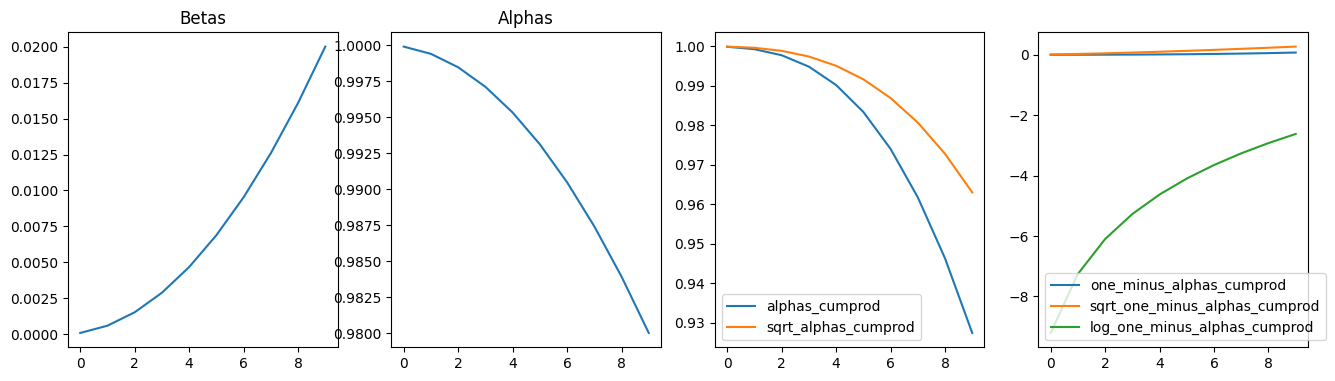

In [269]:
#@title
# Visualizing betas and other variables
plt.figure(figsize=(16, 9))

plt.subplot(2,4,1)
plt.plot(gdb.betas)
plt.title('Betas')
plt.subplot(2,4,2)
plt.plot(gdb.alphas)
plt.title('Alphas')

plt.subplot(2,4,3)
plt.plot(gdb.alphas_cumprod, label='alphas_cumprod')
plt.plot(gdb.sqrt_alphas_cumprod, label='sqrt_alphas_cumprod')
plt.legend();
plt.subplot(2,4,4)
plt.plot(1-gdb.alphas_cumprod, label='one_minus_alphas_cumprod')
plt.plot(gdb.sqrt_one_minus_alphas_cumprod, label='sqrt_one_minus_alphas_cumprod')
plt.plot(gdb.log_one_minus_alphas_cumprod, label='log_one_minus_alphas_cumprod')
plt.legend();

## Forward pass of diffusion model

In the forward pass, the diffused input at timestep t can be computed directly using the closed form equation (For derivation of how we arrive at this, refer to the paper).

$q(x_t| x_0) = N(\sqrt{\bar{\alpha_t}}x_o, 1-\bar{\alpha_t}I)$

This is done in the q_sample function below. 

In [270]:
#make this work with one-dimensional data set 


class DiffusionForward(BetaDerivatives):
  """
  Forward pass of the diffusion model.
  """

  def __init__(self, betas):
    super().__init__(betas)
    

  def q_sample(self, x_start, t, noise=None):
    """
    Forward pass - sample of diffused data at time t.
    """
    if noise is None:
      noise = tf.random.normal(shape=x_start.shape)
    p1 = self._gather(self.sqrt_alphas_cumprod, t) * x_start 
    p2 = self._gather(self.sqrt_one_minus_alphas_cumprod, t) * noise 
    return (p1 + p2)

diff_forward = DiffusionForward(betas_quad)

(10,)


### Visualize the forward diffusion of the entire data over time

We start with original data distribution and move it through the forward diffusion process 10 steps at a time. We can see that the original data distribution information is lost till it resembles gaussian after num_diffusion_steps. 

Also, the slow perturbations at the start and large ones towards the end as per the beta schedule are evident from the video.

[-0.5, -0.5, 0.5, -0.5, -0.5, -0.5, 0.5, 0.5, -0.5, -0.5, 0.5, -0.5, 0.5, -0.5, -0.5, -0.5, -0.5, 0.5, -0.5, -0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
tf.Tensor(
[-0.5 -0.5  0.5 -0.5 -0.5 -0.5  0.5  0.5 -0.5 -0.5  0.5 -0.5  0.5 -0.5
 -0.5 -0.5 -0.5  0.5 -0.5 -0.5  0.5  0.5  0.5  0.5  0.5], shape=(25,), dtype=float32)
tf.Tensor(
[[-0.4916781  -0.47959405  0.5098316  -0.47898272 -0.5042757  -0.5053643
   0.5033381   0.4919556  -0.49649644 -0.5073266   0.5074725  -0.49613604
   0.51524013 -0.5074717  -0.47991815 -0.5127965  -0.4933701   0.50834167
  -0.5044791  -0.49059266  0.50902456  0.48288482  0.48799178  0.4936134
   0.48077488]
 [-0.4916781  -0.47959405  0.5098316  -0.47898272 -0.5042757  -0.5053643
   0.5033381   0.4919556  -0.49649644 -0.5073266   0.5074725  -0.49613604
   0.51524013 -0.5074717  -0.47991815 -0.5127965  -0.4933701   0.50834167
  -0.5044791  -0.49059266  0.50902456  0.48288482  0.48799178  0.4936134
   0.48077488]
 [-0.4916781  -0.47959405  0.5098316  -0.47898272 -0.5042757  -

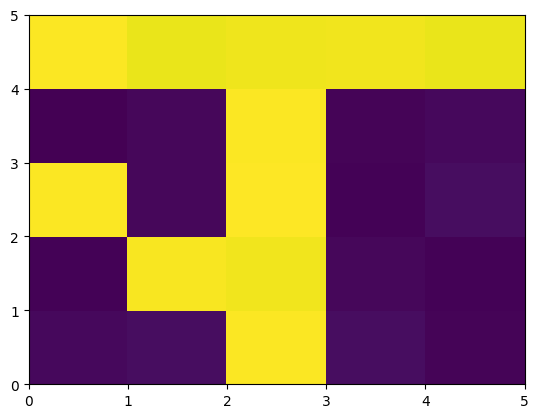

In [271]:
print(one_d_image_data)

train_data_tf = tf.convert_to_tensor(one_d_image_data)
print(train_data_tf)
#print(f'{train_data_tf.shape[0]} samples of {train_data_tf.shape[1]} dimensions in training data')

num_samples_per_center = 5
list = []

def generate_random_image(tensorflow_data, inputted_num_diffusion_timesteps):
  x0 = tensorflow_data[:]
  for timestep in range(0, inputted_num_diffusion_timesteps, 10): 
    tstep = tf.repeat(tf.constant(timestep), (x0.shape[0]))
    shifted = diff_forward.q_sample(x0, tstep)
    #.reshape(5,5)
    
    #c=np.arange(x0.shape[0])//num_samples_per_center
    #plt.legend(f'Time step: {timestep}')
    #print(shifted)

  shifted = shifted.numpy().tolist()
  shifted = shifted[-1]

  #Normalized Image = (Original image - min of image) * ((newMax-newMin) / (ImageMax - ImageMin)) + newMin
  #instead of normalizing to 0 to 255, -0.5 to +0.5 again 
  shifted = np.array(shifted)
  forward_processed_image = (shifted - shifted.min()) * ((0.5+0.5) / (shifted.max()-shifted.min())) -0.5

  forward_processed_image = forward_processed_image.tolist()


  dimensions_based_list = [] 
  forward_processed_image_list = []

  #width determined when image is imported 
  #height doesn't matter 
  foo_number = 0


  for i in forward_processed_image:
    dimensions_based_list.append(i)
    foo_number += 1
    if foo_number % width == 0:
      forward_processed_image_list.append(dimensions_based_list)
      foo_number = 0
      dimensions_based_list = []
  return forward_processed_image_list
     


x0 = train_data_tf[:]
for timestep in range(0, num_diffusion_timesteps, 10): 
  tstep = tf.repeat(tf.constant(timestep), (x0.shape[0]))
  shifted = diff_forward.q_sample(x0, tstep)
  #.reshape(5,5)
  
  #c=np.arange(x0.shape[0])//num_samples_per_center
  #plt.legend(f'Time step: {timestep}')
  #print(shifted)
print(shifted)

shifted = shifted.numpy().tolist()
print("List starts here")
print(shifted)



print("last element in shifted")
print(shifted[-1])
shifted = shifted[-1]

#Normalized Image = (Original image - min of image) * ((newMax-newMin) / (ImageMax - ImageMin)) + newMin
shifted = np.array(shifted)
forward_processed_image = (shifted - shifted.min()) * ((255-0) / (shifted.max()-shifted.min())) + 0


forward_processed_image = forward_processed_image.tolist()

print("after normalization, now list ")
print(forward_processed_image)

dimensions_based_list = [] 
forward_processed_image_list = []

 #width determined when image is imported 
#height doesn't matter 
foo_number = 0


for i in forward_processed_image:
  dimensions_based_list.append(i)
  foo_number += 1
  if foo_number % width == 0:
    forward_processed_image_list.append(dimensions_based_list)
    foo_number = 0
    dimensions_based_list = []
    print("another iteration")
    print(forward_processed_image_list)


plt.pcolor(forward_processed_image_list)


#based on the originial pixel 1 image, everything is flipped over the x axis. so, to print everything as it appears in the list, with first element corresponding
#to lop left pixel, one should pass in the nested lists in reverse order 
#which can be done by iterating through the list that holds the nested lists 

#it seems 255 is yellow and 0 is purple


## Model building

With the data taken care of, let's build a model that can fit the data. We use a DNN with few layers since we're just using data with 2 features that we wish to reconstruct. Would be replaced with unet with similar loss function for the case of image data.

The model takes in 2 inputs:
* Timestep embedding of $t$
* $x_t$

And predicts 
* The noise $n$ that lead from $x_0$ to $x_t$

### Timestep embedding

In [272]:
# We create a 128 dimensional embedding for the timestep input to the model. 
# Fixed embeddings similar to positional embeddings in transformer are used - 
# could be replaced by trainable embeddings later

#timesteps way up there
#embedding_dim, maybe it just gets initialized here. seems that way

def get_timestep_embedding(timesteps, embedding_dim: int):
  half_dim = embedding_dim // 2
  emb = tf.math.log(10000.0) / (half_dim - 1)
  
  #POSITION in time is a vector = function(t)
  #some power of (i), the embedding dimension 
  #128 dimensions = 0 to 127 dimensions

  emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
  emb = tf.cast(timesteps, dtype=tf.float32)[:, None] * emb[None, :]
  emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
  if embedding_dim % 2 == 1:  # zero pad
    # emb = tf.concat([emb, tf.zeros([num_embeddings, 1])], axis=1)
    emb = tf.pad(emb, [[0, 0], [0, 1]])
  return emb

temb = get_timestep_embedding(tf.constant([2,3]),128)
print(temb.shape)
for i in temb:
  print(i)

(2, 128)
tf.Tensor(
[ 9.0929741e-01  9.8767257e-01  9.9697167e-01  9.6080554e-01
  8.9766985e-01  8.2083678e-01  7.3922074e-01  6.5845400e-01
  5.8185095e-01  5.1116455e-01  4.4713849e-01  3.8989139e-01
  3.3917448e-01  2.9453975e-01  2.5544694e-01  2.2132877e-01
  1.9162954e-01  1.6582659e-01  1.4344065e-01  1.2403973e-01
  1.0723901e-01  9.2698507e-02  8.0119617e-02  6.9241248e-02
  5.9835799e-02  5.1705271e-02  4.4677805e-02  3.8604368e-02
  3.3355832e-02  2.8820407e-02  2.4901373e-02  2.1515062e-02
  1.8589128e-02  1.6061027e-02  1.3876693e-02  1.1989400e-02
  1.0358766e-02  8.9498945e-03  7.7326316e-03  6.6809212e-03
  5.7722493e-03  4.9871639e-03  4.3088561e-03  3.7228051e-03
  3.2164624e-03  2.7789876e-03  2.4010139e-03  2.0744489e-03
  1.7923010e-03  1.5485276e-03  1.3379101e-03  1.1559390e-03
  9.9871797e-04  8.6288073e-04  7.4551901e-04  6.4411951e-04
  5.5651210e-04  4.8081978e-04  4.1542295e-04  3.5892046e-04
  3.1010329e-04  2.6792553e-04  2.3148466e-04  1.9999998e-04
 -4.

In [273]:
#take a sample of a REAL image from your entire set of real images.

random_number_timesteps = randrange(0, num_diffusion_timesteps)
print(random_number_timesteps)
generate_random_image(train_data_tf, num_diffusion_timesteps)

#sample noise LEVEL t between 1 and T (not necessarily max t)



#sample noise from gaussian distribution and corrupt input (first/former sample) by sampled noise/noise at t

#neural network predicts future noise by equating your newly produced corrupted image (steps 1-3) to calculable noise (given Beta is known and t is known, regardless of how it was randomly chosen) applied to original image 

0


[[-0.4853888005752454,
  -0.4608121827118697,
  0.4867002725847499,
  -0.48131875476418334,
  -0.47722885998961745],
 [-0.4802293952490397,
  0.4785146925542476,
  0.471766217813134,
  -0.483662142408967,
  -0.5],
 [0.4925362711719876,
  -0.458123123495123,
  0.4631739500935408,
  -0.48631061063939013,
  -0.4782623312766081],
 [-0.47103851851254347,
  -0.48364301365458884,
  0.48956249888367587,
  -0.4828914610277557,
  -0.4791082312989058],
 [0.4947034668562641,
  0.5,
  0.488564634735859,
  0.4907705488627322,
  0.496270353830101]]

In [274]:
# Actual model that takes in x_t and t and outputs n_{t-1}
# Experiments showed that prediction of n_{t-1} worked better compared to
# prediction of x_{t-1}

print(train_data_tf)

def build_model():
  input_x = tf.keras.layers.Input(train_data_tf.shape[0]) #.shape[1], shape[0] probably worked because it looked in the tensor for shape and only needed the first parameter
  temb = tf.keras.layers.Input(128)

  # temb = tf.keras.layers.Reshape((128,))(tf.keras.layers.Embedding(1000, 128)(input_t))
  d1 = tf.keras.layers.Dense(128)(input_x)
  merge = tf.keras.layers.Concatenate()((temb, d1))
  d2 = tf.keras.layers.Dense(128, 'relu')(merge)
  d2 = tf.keras.layers.Dense(64, 'relu')(d2)
  d2 = tf.keras.layers.Dense(32, 'relu')(d2)
  d3 = tf.keras.layers.Dense(16, 'relu')(d2)
  d4 = tf.keras.layers.Dense(2)(d3)
  model = tf.keras.Model([input_x, temb], d4)
  return model

model = build_model()
print(model.summary())
model.compile(loss='mse', optimizer='adam')

tf.Tensor(
[-0.5 -0.5  0.5 -0.5 -0.5 -0.5  0.5  0.5 -0.5 -0.5  0.5 -0.5  0.5 -0.5
 -0.5 -0.5 -0.5  0.5 -0.5 -0.5  0.5  0.5  0.5  0.5  0.5], shape=(25,), dtype=float32)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 25)]                 0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 dense_42 (Dense)            (None, 128)                  3328      ['input_17[0][0]']            
                                                                                                  
 concatenate_7 (Concate

### Data generation for diffusion model

Next, let's generate the data for the model to train. We generate $x_t$ given the input $x_0$ using the deterministic forward process equation described above. This $x_t$ and timestep embedding of 
$t$ are input to the model that is tasked with predicting the noise $n$.

$t$ is picked uniformly between [0, num_diffusion_timesteps]

In [275]:
#generate 1000 5x5 random images
training_data = []
for i in range (0, 999):
    training_data.append(generate_random_image(train_data_tf, num_diffusion_timesteps))




In [276]:
shuffle_buffer_size = 125 #1000 generated by me and prev ex used 1000 from 8000 points
batch_size = 32

print(train_data_tf)

def data_generator_forward(x, gdb):
  tstep = tf.random.uniform(shape=(tf.shape(x)[0],), minval=0, maxval=num_diffusion_timesteps, dtype=tf.int32)
  print(tf.shape(x[0]))
  
  print("ELEMENTS IN TSTEP")
  for i in tstep:
    print(i)


  #tensor of specified shape with random uniform values
  noise = tf.random.normal(shape = tf.shape(x), dtype=x.dtype)

  print ("FIND NOISE")
  print(noise)

  #random values from normal distribution 
  noisy_out = gdb.q_sample(x, tstep, noise)
  #qsample runs the mean change + epsilon thing
  return ((noisy_out, get_timestep_embedding(tstep, 128)), noise) 
  


# Model takes in noisy output and timestep embedding and predicts noise
dataset = tf.data.Dataset.from_tensor_slices((train_data_tf)).shuffle(shuffle_buffer_size).batch(batch_size)

dataset = dataset.map(functools.partial(data_generator_forward, gdb=diff_forward))
#map = x part, gdb = diff_forward
#dataset is a Tensorflow object, a slice from train_data_tf (8000 points)
  #shuffle randomize the order all the 8000 points are stored in
  #batch size: groups of 32 points 

print("ELEMENTS IN DATASET")
for element in dataset:
  print(element)

tf.Tensor(
[-0.5 -0.5  0.5 -0.5 -0.5 -0.5  0.5  0.5 -0.5 -0.5  0.5 -0.5  0.5 -0.5
 -0.5 -0.5 -0.5  0.5 -0.5 -0.5  0.5  0.5  0.5  0.5  0.5], shape=(25,), dtype=float32)
Tensor("Shape_1:0", shape=(0,), dtype=int32)
ELEMENTS IN TSTEP
Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(), dtype=int32)
FIND NOISE
Tensor("random_normal:0", shape=(None,), dtype=float32)
ELEMENTS IN DATASET
((<tf.Tensor: shape=(25, 25), dtype=float32, numpy=
array([[ 0.50966096,  0.5280996 ,  0.49141192, -0.5004046 , -0.49388874,
        -0.48974493,  0.4907585 ,  0.5088421 ,  0.5129234 , -0.50202596,
         0.44209623,  0.53490067,  0.5078192 , -0.5205182 , -0.49526247,
        -0.49574074, -0.5216637 , -0.4820571 , -0.47529304, -0.49724543,
        -0.46219438, -0.4954016 ,  0.52761084,  0.49539396, -0.50284517],
       [ 0.5722376 ,  0.7331533 ,  0.41297626, -0.49145645, -0.43459174,
        -0.39842838,  0.40727404,  0.56509125,  0.6007096 , -0.5056064 ,
        -0.01740667,  0.79250705,  0.5561

In [277]:
# Let's test the data generator
(xx,tt),yy = next(iter(dataset))
print(xx.shape, tt.shape, yy.shape)

(25, 25) (25, 128) (25,)


### Train and evaluate the model

In [278]:
num_epochs = 200
history = model.fit(training_data, epochs=num_epochs) #(dataset, this epochs)

Epoch 1/200


ValueError: in user code:

    File "/Users/Justin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/Justin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/Justin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/Justin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Users/Justin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/Justin/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_7" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 5, 5) dtype=float32>]


In [ ]:
class DiffusionReconstruct(BetaDerivatives):
  
  def __init__(self, betas):
    super().__init__(betas)

    self.sqrt_recip_alphas_cumprod = tf.math.sqrt(1. / self.alphas_cumprod)
    self.sqrt_recipm1_alphas_cumprod = tf.math.sqrt(1. / self.alphas_cumprod - 1)
    
    # calculations required for posterior q(x_{t-1} | x_t, x_0)
    # Variance choice corresponds to 2nd choice mentioned in the paper
    self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)  
    
    
    # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
    self.posterior_log_variance_clipped = tf.constant(np.log(np.maximum(self.posterior_variance, 1e-20)))
    self.posterior_mean_coef1 = self.betas * tf.math.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
    self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * tf.math.sqrt(self.alphas) / (1. - self.alphas_cumprod)
  
  def predict_start_from_noise(self, x_t, t, noise):
    """
    Reconstruct x_0 using x_t, t and noise. Uses deterministic process
    """
    return (
        self._gather(self.sqrt_recip_alphas_cumprod, t) * x_t -
        self._gather(self.sqrt_recipm1_alphas_cumprod, t) * noise
    )

  def q_posterior(self, x_start, x_t, t):
    """
    Compute the mean and variance of the diffusion posterior q(x_{t-1} | x_t, x_0)
    """
    posterior_mean = (
        self._gather(self.posterior_mean_coef1, t) * x_start +
        self._gather(self.posterior_mean_coef2, t) * x_t
    )
    posterior_log_variance_clipped = self._gather(self.posterior_log_variance_clipped, t)
    return posterior_mean, posterior_log_variance_clipped

  def p_sample(self, model, x_t, t):
    """
    Sample from the model. This does 4 things
    * Predict the noise from the model using x_t and t
    * Create estimate of x_0 using x_t and noise (reconstruction)
    * Estimate of model mean and log_variance of x_{t-1} using x_0, x_t and t
    * Sample data (for x_{t-1}) using the mean and variance values
    """
    noise_pred = model((x_t, get_timestep_embedding(t, 128))) # Step 1
    x_recon = self.predict_start_from_noise(x_t, t=t, noise=noise_pred) # Step 2
    model_mean, model_log_variance = self.q_posterior(x_start=x_recon, x_t=x_t, t=t) # Step 3
    noise = noise_like(x_t.shape)
    nonzero_mask = tf.reshape(tf.cast(tf.greater(t, 0), tf.float32), (x_t.shape[0], 1)) 
    return model_mean + tf.exp(0.5 * model_log_variance) * noise * nonzero_mask # Step 4

  def p_sample_loop_trajectory(self, model, shape):
    """
    Generate the visualization of intermediate steps of the reverse of diffusion
    process.
    """
    times = tf.Variable([self.num_timesteps - 1], dtype=tf.int32)
    imgs = tf.Variable([noise_like(shape)])
    times, imgs = tf.while_loop(
      cond=lambda times_, _: tf.greater_equal(times_[-1], 0),
      body=lambda times_, imgs_: [
        tf.concat([times_, [times_[-1] - 1]], axis=0),
        tf.concat([imgs_, [self.p_sample(model=model,
                                         x_t=imgs_[-1],
                                         t=tf.fill([shape[0]], times_[-1]))]], 
                  axis=0)
      ],
      loop_vars=[times, imgs],
      shape_invariants=[tf.TensorShape([None, 1]),
                        tf.TensorShape([None, *shape])],
      back_prop=False
    )
    return times, imgs

In [ ]:
rec_diff = DiffusionReconstruct(betas_quad)
pred_ts, pred_data = rec_diff.p_sample_loop_trajectory(model, shape=(1000,2))

(10,)
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 25), found shape=(1000, 2)